In [1]:
import os
import re
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()
mmpix = 0.01 # mm, we are using CCF with 10 um resolution
bregma = np.array([540, 0, 570]) # AP, DV, LR,
# from https://github.com/cortex-lab/allenCCF/blob/master/Browsing%20Functions/allenCCFbregma.m

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Average number of cortical electrodes per probe (extracted from 569069, 569072, 569073, 571619)

# Combined EEG/LFP plots with PCI and PCs

### Load experiment instance and data

In [7]:
dfolder = r'F:\EEG_exp\mouse571620\estim_vis_2021-05-13_11-33-47\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

In [10]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()

## Get bad_ch_list from metadata ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

## Get electrode location from metadata ##
stim_elec_str = exp_meta['CCF coordinates stim electrode (surface,tip)']
if stim_elec_str is None or stim_elec_str == '':
    print('No stim electrode coordinates for this experiment, using estimates.')
    probe_locs = {
        'stim': {'AP': -1.3, 'ML': -1.8}
    }
elif stim_elec_str == 'not visible':
    print('Stim electrode was not visible in histology: no coordinates for this experiment, using estimates.')
    probe_locs = {
        'stim': {'AP': -1.1, 'ML': -1.45}
    }
else:
    stim_elec_coords = []
    for char in stim_elec_str.split('],'):
        temp_coords = []
        for val in char.split(','):
            temp_coords.append(int(re.sub(r'\W+', '', val)))
        stim_elec_coords.append(np.array(temp_coords))
    stim_elec_coords = np.array(stim_elec_coords)
    probe_locs = {
        'stim': {
            'AP': (bregma[0] - stim_elec_coords[0,0]) * mmpix,
            'ML': (stim_elec_coords[0,2] - bregma[2]) * mmpix
        }
    }

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14]


### What to do if we don't have stim or probe locations in log file??

In [11]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)
for probei in probe_list:
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    if 'area_ch' in data.keys():
        probe_locs[probei] = {}
        probe_surface_CCF = np.array(data['ccf_coord_ch'])[surface_ch]
        probe_locs[probei]['AP'] = (bregma[0] - probe_surface_CCF[0]) * mmpix
        probe_locs[probei]['ML'] = (probe_surface_CCF[2] - bregma[2]) * mmpix
    else:
        print('{} does not have area assignments.'.format(probei))

['probeB', 'probeC', 'probeF']


<IPython.core.display.Javascript object>


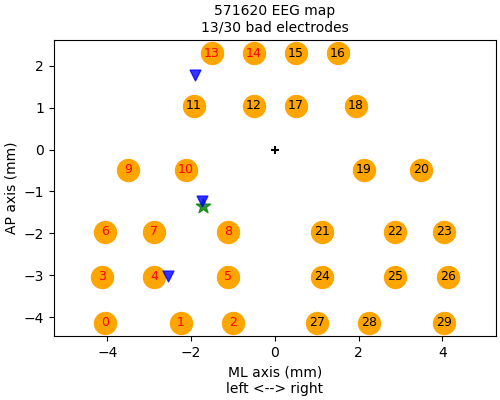

Text(0.5, 1.0, '571620 EEG map\n13/30 bad electrodes')

In [12]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], s=250, color='orange')
ax.scatter(0, 0, marker='+', color='k')
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    if ind in bad_chs:
        textc = 'r'
    else:
        textc = 'k'
    ax.annotate(
        str(ind), ha='center', va='center', color=textc, fontsize=9,
        xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]),
    )
for thing, coords in probe_locs.items():
    if 'probe' in thing:
        tmarker = 'v'
        tcolor = 'b'
        tsize = 60
    else:
        tmarker = '*'
        tcolor = 'g'
        tsize = 120
    ax.scatter(coords['ML'], coords['AP'], marker=tmarker, color=tcolor, s=tsize, alpha=0.8)

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('{} EEG map\n{:d}/30 bad electrodes'.format(exp.mouse, len(bad_chs)))

Load stimulus log and speed

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,80,477.89069,477.89109,0.0004,0,True
1,biphasic,60,481.42371,481.42411,0.0004,0,True
2,biphasic,80,485.48534,485.48574,0.0004,0,True
3,biphasic,100,489.86763,489.86803,0.0004,0,True
4,biphasic,100,494.03723,494.03764,0.0004,0,True


In [14]:
run_signal, run_timestamps = exp.load_running()

Get event times, resting for awake and anesthetized

In [15]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
comp_states = {
    'SSp_500': {'awake': [0], 'anesthetized': [3]},
    'SSp_900': {'awake': [1], 'anesthetized': [2]},
}
# 'MOs_500': {'awake': [0], 'anesthetized': [1]},
# 'SSp_1000': {'awake': [0], 'anesthetized': [1]},
rest_trials_only = True
amp_list = sorted(stim_log[stim_log['stim_type']==stim_type].parameter.unique(), key=lambda x: int(x))

all_event_times = {}
all_trial_counts = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    all_trial_counts[expdes] = {}
    for parami in amp_list:
        print(' biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        state_trial_count = []
        for statei, sweeps in state_sweeps.items():
            
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, stim_type, parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)
            
            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed < 0.5)[0]
            print('  {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))
            state_trial_count.append(len(rest_events))
            
            if rest_trials_only:
                ## Keep resting event times ##
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events
        all_trial_counts[expdes][parami] = state_trial_count

SSp_500
 biphasic - 60 μA
  awake state: resting trials 94/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 94/120
  anesthetized state: resting trials 120/120
 biphasic - 100 μA
  awake state: resting trials 89/120
  anesthetized state: resting trials 120/120
SSp_900
 biphasic - 60 μA
  awake state: resting trials 105/120
  anesthetized state: resting trials 120/120
 biphasic - 80 μA
  awake state: resting trials 105/120
  anesthetized state: resting trials 120/120
 biphasic - 100 μA
  awake state: resting trials 107/120
  anesthetized state: resting trials 120/120


#### Load data and collect traces

Set ERP parameters

In [16]:
before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s
response_win = [0.005, 0.8]
z_threshold = 5

## EEG params ##
apply_mask = True
apply_hpass = True
apply_car = True

Set PCI paramters

In [17]:
PCI_params = {
    'baseline_window': (-0.8, -0.001), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.001, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

Get ERPs and calculate PCI

In [18]:
## Load EEG data and good chs ##
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]
        
## Apply high-pass filter ##
if apply_hpass:
    start = time.time()
    hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
    eeg_data = signal.filtfilt(hpb, hpa, eeg_data, axis=0)
    end = time.time()
    print('Time to highpass filter: {:.2f} s\n'.format((end - start)))

fullPCI = {}
erp_limits = {}
erp_duration = {}
for expdes in all_event_times.keys():
    print(expdes)
    fullPCI[expdes] = {}
    erp_duration[expdes] = {}
    max_vals = []
    min_vals = []
    for parami in all_event_times[expdes].keys():
        fullPCI[expdes][parami] = {}
        erp_duration[expdes][parami] = {}
#         NUM_TRIALS = min(all_trial_counts[expdes][parami]) # this won't work if we are using all trials
        NUM_TRIALS = min([len(all_event_times[expdes][parami][x]) for x in all_event_times[expdes][parami].keys()])
        for statei, event_times in all_event_times[expdes][parami].items():
            ## EEG traces ##
            start = time.time()
            eeg_event_traces, eeg_event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                event_times[:NUM_TRIALS],
                before_event,
                after_event,
                exp.ephys_params['EEG']['sample_rate']
            )
            ## Common average reference ##
            if apply_car:
                eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

            ## Design and apply Butterworth filter ##
            filtb, filta = signal.butter(
                3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='lowpass')
            EEG_ERP = np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)
            max_vals.append(np.max(EEG_ERP[:, GOOD_CHS]))
            min_vals.append(np.min(EEG_ERP[:, GOOD_CHS]))
            
            ## z-traces ##
            preinds = np.nonzero((eeg_event_ts >= -response_win[1]) & (eeg_event_ts <= -response_win[0]))[0]
            postinds = np.nonzero((eeg_event_ts >= response_win[0]) & (eeg_event_ts <= response_win[1]))[0]
            z_traces = ((EEG_ERP - np.mean(EEG_ERP[preinds,:], axis=0)) / np.std(EEG_ERP[preinds,:], axis=0))
            ch_dur = []
            for chi in GOOD_CHS:
                zinds = np.nonzero(np.abs(z_traces[postinds,chi]) > z_threshold)[0]
                if ((zinds.size > 0) and (eeg_event_ts[postinds][zinds[-1]] > 0)):
                    ch_dur.append(eeg_event_ts[postinds][zinds[-1]])
            if len(ch_dur) > 0:
                erp_duration[expdes][parami][statei] = np.array(ch_dur)
            else:
                erp_duration[expdes][parami][statei] = np.array([0])
            
            ## PCI for EEG ERPs ##
            fullPCI[expdes][parami][statei] = calc_PCIst(
                EEG_ERP[:, GOOD_CHS].T, eeg_event_ts, full_return=True, **PCI_params
            )
            end = time.time()
            print(' {} - {}: EEG PCI time = {:.2f} min'.format(parami, statei, (end-start)/60))
    erp_limits[expdes] = [min(min_vals) - 20, max(max_vals) + 20]

Time to highpass filter: 36.01 s

SSp_500
 60 - awake: EEG PCI time = 0.63 min
 60 - anesthetized: EEG PCI time = 0.33 min
 80 - awake: EEG PCI time = 0.63 min
 80 - anesthetized: EEG PCI time = 0.33 min
 100 - awake: EEG PCI time = 0.63 min
 100 - anesthetized: EEG PCI time = 0.33 min
SSp_900
 60 - awake: EEG PCI time = 1.59 min
 60 - anesthetized: EEG PCI time = 0.03 min
 80 - awake: EEG PCI time = 1.85 min
 80 - anesthetized: EEG PCI time = 1.55 min
 100 - awake: EEG PCI time = 1.56 min
 100 - anesthetized: EEG PCI time = 1.57 min


## Big combo plot

<IPython.core.display.Javascript object>


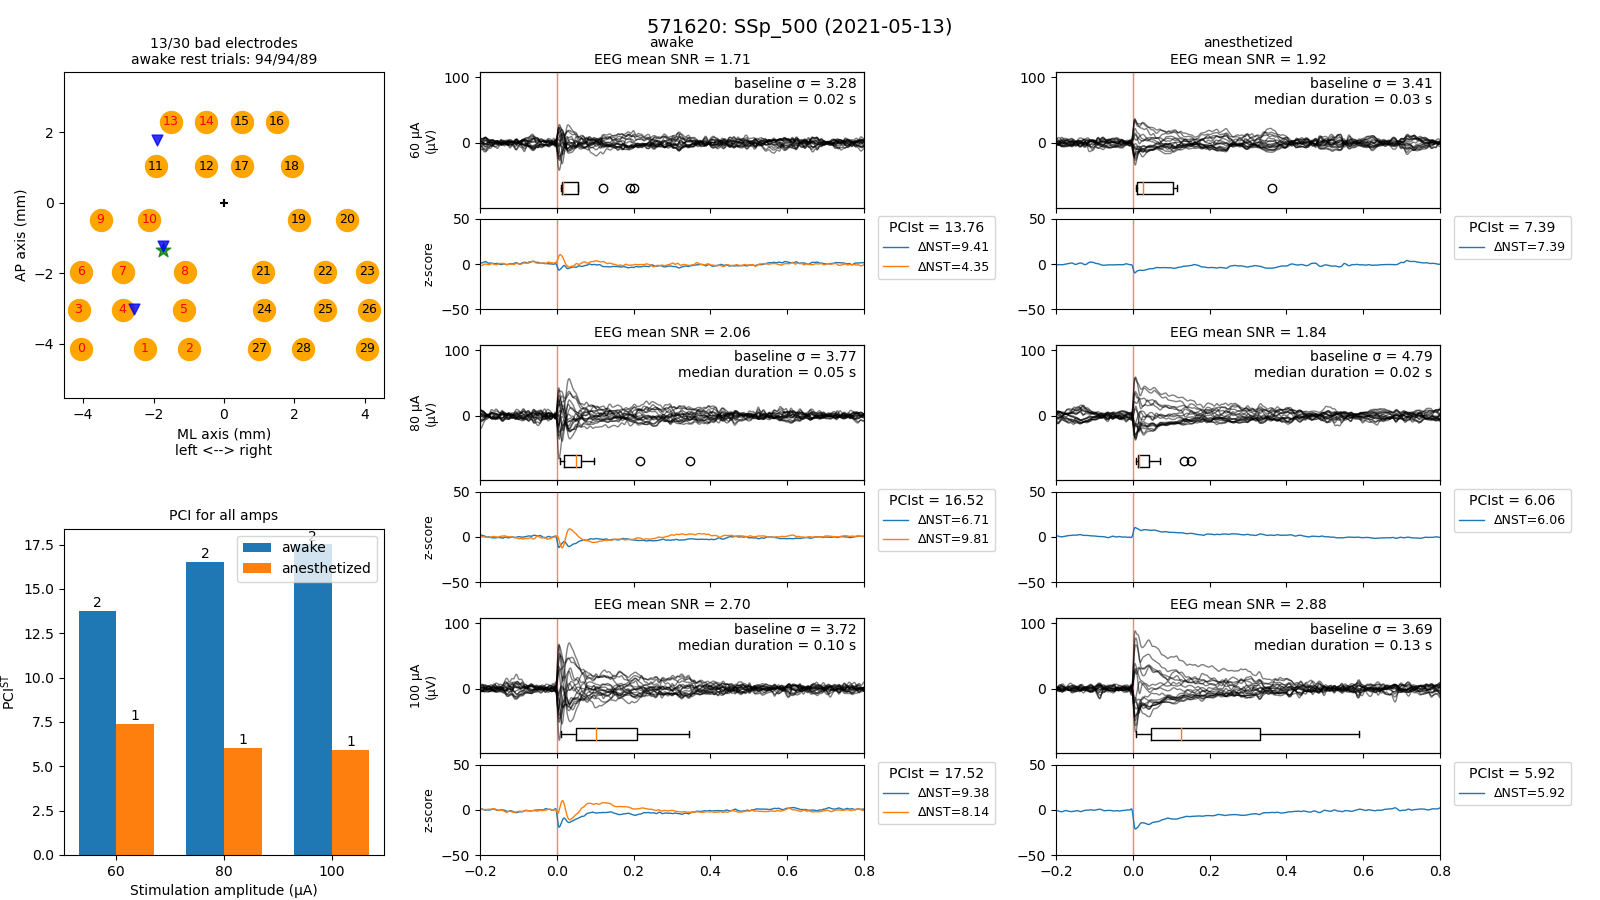

<IPython.core.display.Javascript object>


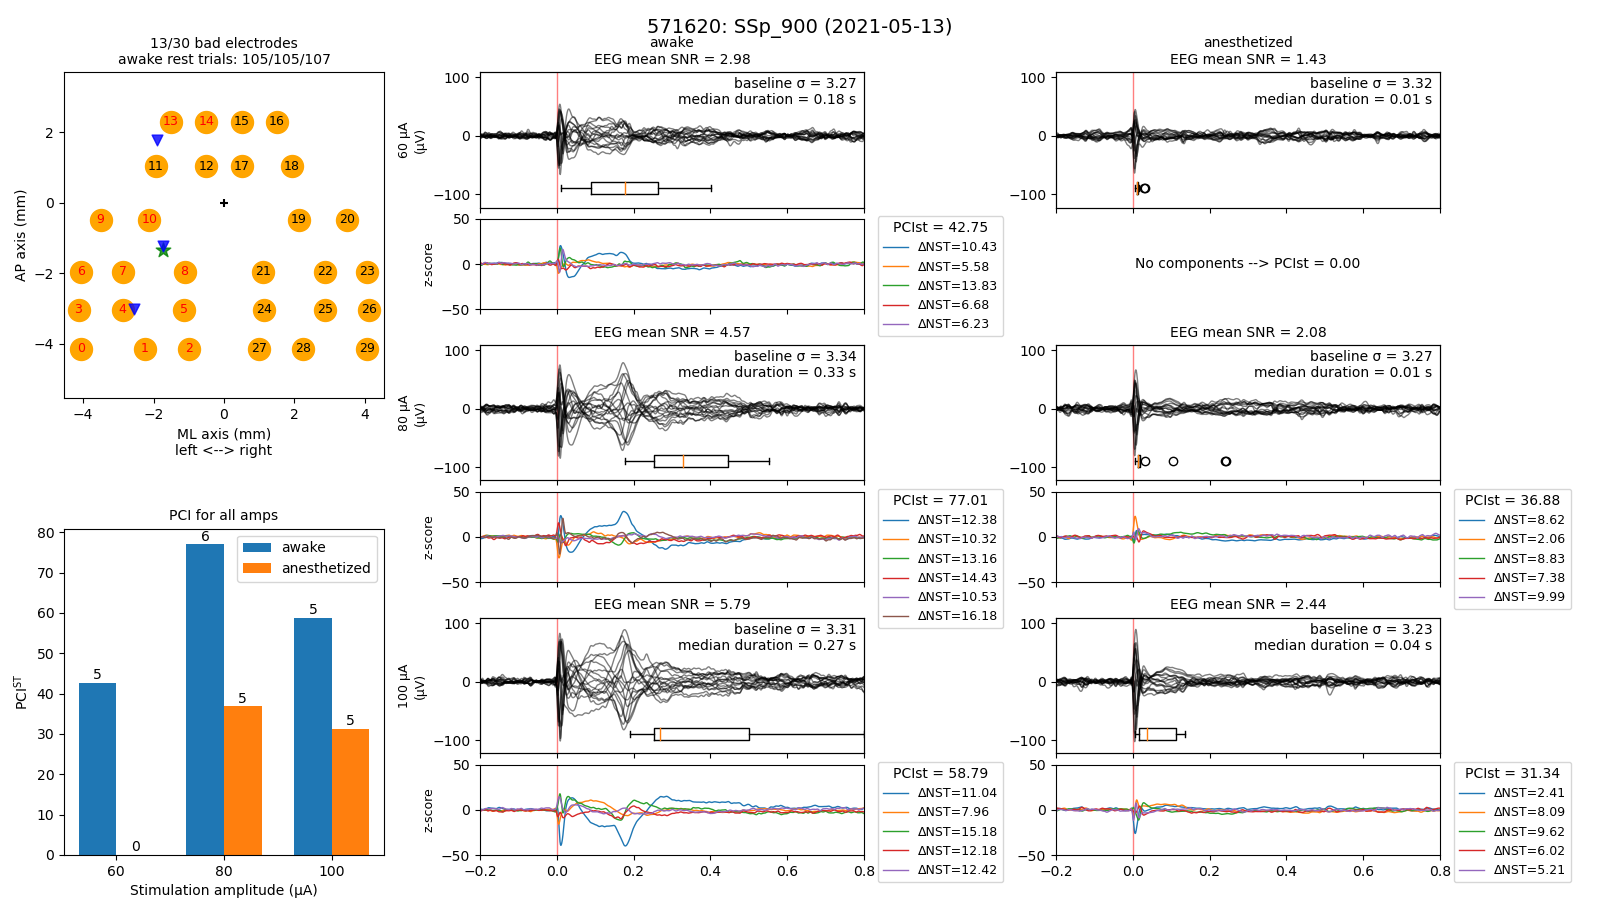

In [21]:
plwin = [-0.2, 0.8]
PCcolors = [cm.tab10(x) for x in np.linspace(0, 1, 10)]
width = 0.35 # the width of the bars
bar_colors = {'awake': 'tab:blue', 'anesthetized': 'tab:orange'}

for expdes in fullPCI.keys():
    ## Labels for PCI bar plot ##
    labels = list(fullPCI[expdes].keys())
    x = np.arange(len(labels)) # the label locations
    
    ## Initialize figure ##
    fig = plt.figure(figsize=(16,9))
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1,3], top=0.92, bottom=0.05, left=0.04, right=0.9, wspace=0.15)
    
    leftgs = gs[0, 0].subgridspec(2, 1, hspace=0.4) # , height_ratios=[3,2]
    
    ## Plot array ##
    arrayax = fig.add_subplot(leftgs[0])
    arrayax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], s=250, color='orange')
    arrayax.scatter(0, 0, marker='+', color='k')
    arrayax.axis('equal')
    for ind in range(len(EEGexp.EEG_channel_coordinates)):
        if ind in bad_chs:
            textc = 'r'
        else:
            textc = 'k'
        arrayax.annotate(
            str(ind), ha='center', va='center', color=textc, fontsize=9,
            xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]),
        )
    for thing, coords in probe_locs.items():
        if 'probe' in thing:
            tmarker = 'v'
            tcolor = 'b'
            tsize = 60
        else:
            tmarker = '*'
            tcolor = 'g'
            tsize = 120
        arrayax.scatter(coords['ML'], coords['AP'], marker=tmarker, color=tcolor, s=tsize, alpha=0.8)
    arrayax.set_xlabel('ML axis (mm)\nleft <--> right')
    arrayax.set_ylabel('AP axis (mm)')
    arrayax.set_title(
        '{:d}/30 bad electrodes\nawake rest trials: '.format(len(bad_chs)) +
        '/'.join('%d' % all_trial_counts[expdes][ampi][0] for ampi in all_trial_counts[expdes].keys())
    )
    
    ## Make bar axes ##
    barax = fig.add_subplot(leftgs[1])
    
    rightgs = gs[0, 1].subgridspec(
        ncols=len(comp_states[expdes].keys()), nrows=len(fullPCI[expdes].keys()), hspace=0.15, wspace=0.5
    )
    for rowi, (paramii, paramdict) in enumerate(fullPCI[expdes].items()):
        for coli, (statei, datai) in enumerate(paramdict.items()):
            gsrc = rightgs[rowi, coli].subgridspec(2, 1, height_ratios=[3,2], hspace=0.1)
            timex = datai['times']
            pinds = np.squeeze(np.argwhere((timex >= plwin[0]) & (timex <= plwin[1])))
            ## evoked response ##
            traces = datai['signal_evk'].T
            ## get baseline std ##
            binds = np.squeeze(np.argwhere((timex >= -0.8) & (timex < -0.001)))
            blstd = np.mean(np.std(traces[binds, :], axis=0))
            ## get SNR ##
            rinds = np.squeeze(np.argwhere((timex > 0.001) & (timex <= 0.8)))
            base_power = np.mean(np.square(traces[binds, :]), axis=0)
            resp_power = np.mean(np.square(traces[rinds, :]), axis=0)
            snrs = np.sqrt(resp_power / base_power)

            ## PLOT EEG ##
            axeeg = fig.add_subplot(gsrc[0])
            axeeg.axvline(0, color='r', linewidth=1, alpha=0.5)
            axeeg.plot(timex[pinds], traces[pinds, :], color='k', linewidth=1, alpha=0.5)
            axeeg.text(
                0.98, 0.85, ('baseline \u03C3 = {:.2f}\nmedian duration = {:.2f} s'.format(
                    blstd, np.median(erp_duration[expdes][paramii][statei]))),
                horizontalalignment='right', verticalalignment='center', transform=axeeg.transAxes
            )
            axeeg.set_xlim(plwin)
            axeeg.set_xticklabels([])
            axeeg.set_ylim(erp_limits[expdes])
            if coli > 0:
                axeeg.sharey(axeeg)
            else:
                axeeg.set_ylabel('{} \u03bcA\n(\u03bcV)'.format(paramii), fontsize=9)
            if rowi == 0:
                axeeg.set_title('{}\nEEG mean SNR = {:.2f}'.format(statei, np.mean(snrs)))
                bar_label = statei
            else:
                axeeg.set_title('EEG mean SNR = {:.2f}'.format(np.mean(snrs)))
                bar_label = None
            
#             if len(erp_duration[expdes][paramii][statei]) > 1:
            axbox = axeeg.twinx()
            axbox.boxplot(erp_duration[expdes][paramii][statei], vert=False)
            axbox.set_ylim([0.75,2.5])
            axbox.set_yticks([])
                
            ## PCI BAR PLOT ##
            barax.bar(x[rowi] + (width) * coli, datai['PCI'], width, color=bar_colors[statei], label=bar_label)
            barax.annotate(
                '{}'.format(datai['n_dims']), xy=(x[rowi] + (width) * coli , datai['PCI']),
                xytext=(0, 0.5), textcoords="offset points", ha='center', va='bottom'
            )

            ## PLOT PCs ##
            axpc = fig.add_subplot(gsrc[1])
            PCs = datai['signal_svd'].T
            if PCs.size == 0:
                axpc.text(
                    0.5, 0.5, ('No components --> PCIst = {:.2f}'.format(datai['PCI'])),
                    horizontalalignment='center', verticalalignment='center', transform=axpc.transAxes
                )
                axpc.axis('off')
            else:
                ## PC z-score ##
                PCz = (PCs - np.mean(PCs[binds, :], axis=0)) / np.std(PCs[binds, :], axis=0)
                axpc.axvline(0, color='r', linewidth=1, alpha=0.5)
                for iPC in range(PCz.shape[1]):
                    axpc.plot(
                        timex[pinds], PCz[pinds, iPC], color=PCcolors[iPC], linewidth=1,
                        label='\u0394NST={:.2f}'.format(datai['dNST'][iPC])
                    )
                axpc.set_xlim(plwin)
                axpc.set_ylim([-50, 50])
                axpc.legend(
                    bbox_to_anchor=(1.02, 1.1), loc='upper left',
                    title='PCIst = {:.2f}'.format(datai['PCI']), fontsize=9
                )
#                 axpc.sharey(axs[1, 0])
                if coli == 0:
                    axpc.set_ylabel('z-score', fontsize=9)
                if rowi < len(fullPCI[expdes].keys())-1:
                    axpc.set_xticklabels([])
        
        ## Bar plot labels ##
        barax.set_xlabel('Stimulation amplitude (\u03BCA)')
        barax.set_ylabel('$\mathregular{PCI^{ST}}$')
        barax.set_xticks(x + width/2)
        barax.set_xticklabels(labels)
        barax.set_title('PCI for all amps')
        barax.legend()
        plt.suptitle('{}: {} ('.format(exp.mouse, expdes) + exp.date.strftime('%Y-%m-%d') + ')', fontsize=14)

        ## Save ##
        figname = 'EEGsummary_wPCI_PCs_{}_{}.png'.format(exp_tag, expdes)
        fig.savefig(os.path.join(plotsavedir, figname), transparent=True)